# DEA Land Cover pixel drill <img align="right" src="../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/products/ga_ls_landcover_class_cyear_2)

## Background 
Land cover is the observed biophysical cover of the Earth's surface. The Digital Earth Australia (DEA) Land Cover product classifies the Australian continent's surface using the [FAO LCCS taxonomy](https://www.fao.org/3/x0596e/x0596e00.htm), providing detailed information on the presence of water, vegetation cover and the urban environment. For a more in-depth introduction to the DEA Land Cover dataset, see the [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) and the [DEA Land Cover product details](https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat#details) page.

Trends in land cover over time provide important information about environmental conditions and human activity. For example, measuring change in land cover over time can describe the natural cycles of greening and drying in an ephemeral wetland, or show how an ecosystem responds after a bushfire.

## Description 

A pixel drill is a method of analysing time-deep satellite data; a single spatial point is chosen and the characteristics of that point through time are plotted. This notebook conducts a pixel drill on the Level 3 classification layer of the DEA Land Cover product, visualising how this location on Australia's surface has or has not changed over 30+ years. 

1.	Select an area of interest and load data.
2.	Visualise the data and select point for pixel drill.
3.	Conduct pixel drill.
4.	Plot land cover history of the chosen point.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the 'Load packages and connect to the datacube' cell. 

### Load packages and connect to the datacube

In [1]:
%matplotlib widget

import os
import sys

import datacube
import matplotlib.pyplot as plt

sys.path.insert(1, os.path.abspath("../../Tools"))
from dea_tools.land_cover import lc_colourmap
from dea_tools.plotting import display_map

In [2]:
dc = datacube.Datacube(app='DEA_Land_Cover')

### Define custom functions

This notebook uses the following custom functions to format the data and create the interactive plot.

In [3]:
def rescale_level3(data):
    """
    Rescale distribution of Level 3 classes to be 0-6 for neat plotting in pixel drill plot.
    Input: xarray DataSet or DataArray containing Level 3 land cover data.
    """
    scale_and_lables = {0: 0, 111: 1, 112: 2, 124: 3, 215: 4, 216: 5, 220: 6}

    for key, value in scale_and_lables.items():
        data = data.where(data != key, value)
    return data


def click_for_coords(event):
    """
    Define behaviour widget to enable extraction of x,y values for point manually selected with mouse click on interactive plot.
    For use with Matplotlib Imshow.
    The x and y returned are the coordinate positions of the pixel in the x and y axis, rather than latitude/longitude values of the point.
    The coordinate positions of the pixel this is what you need later to conduct a pixel drill.
    Returns: ix, iy = position of selected pixel in the x and y coordinates of the array.
    """
    global ix, iy
    ix, iy = event.xdata, event.ydata
    global coords
    coords.append((ix, iy))

    fig.canvas.mpl_disconnect(cid)
    return

## 1. Define area of interest and load data

In [4]:
# Select central coordinates for an area of interest
# Lake George
point_x, point_y = (-35.1064, 149.4248)

# Combine central coordinates with buffer values to create the latitude and longitude range
lat = (point_x - 0.1, point_x + 0.1)
lon = (point_y - 0.1, point_y + 0.1)

# Display area on map
display_map(x=lon, y=lat)

In [5]:
# Create the 'query' dictionary object, which contains the coordinates defined above
query = {
    "y": lat,
    "x": lon,
    "time": ("1988", "2020"),
}

# Load DEA Land Cover data from the datacube
all_data = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements=["level3"],
    resolution=(-25, 25),
    **query
)

In [6]:
# Have a look at the data we loaded
all_data

<xarray.Dataset>
Dimensions:      (time: 33, y: 982, x: 842)
Coordinates:
  * time         (time) datetime64[ns] 1988-01-01 1989-01-01 ... 2020-01-01
  * y            (y) float64 -3.93e+06 -3.93e+06 ... -3.954e+06 -3.954e+06
  * x            (x) float64 1.569e+06 1.569e+06 1.569e+06 ... 1.59e+06 1.59e+06
    spatial_ref  int32 3577
Data variables:
    level3       (time, y, x) uint8 112 112 112 112 111 ... 112 112 112 112 112
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [7]:
# Select Level 3
level3 = all_data.level3

## 2. Visualise the data and select point for pixel drill

This plot has an interactive function enabled which allows users to select a specific point to analyse in greater detail further down the notebook. To use this feature, select a point on the plot you wish to interrogate by clicking on it with your mouse. Then run the next code cell below. The point you selected will then be highlighted on this plot with a red dot.
The most recent year has been set as default to visualise in this step.
#### Troubleshooting:
You can move the dot by clicking on a new location and then re-running the next cell after the interactive plot again. Unless you have since completed the notebook and generated the graph at the end, in which case you need to re-run this code first in order to re-generate the interactive plot before selecting a new point.
If you click multiple times on the plot before running the next piece of code only the most recent location will be used.
If you run into trouble, restarting the kernel of the notebook and running from the first cell again may help.


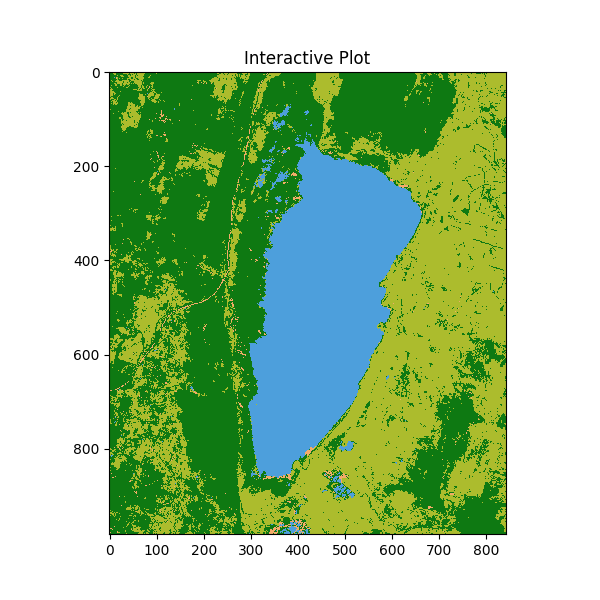

In [8]:
# Build the colour map for level 3
layer_cmap, layer_norm = lc_colourmap("level3")

# Select year to plot
plot_year = "2020"

# Create interactive plot
fig, ax = plt.subplots(figsize=(6, 6))
ax = plt.imshow(
    level3.sel(time=plot_year, method="nearest").squeeze(),
    cmap=layer_cmap,
    norm=layer_norm,
    interpolation="nearest",
)
cid = fig.canvas.mpl_connect("button_press_event", click_for_coords)
plt.title("Interactive Plot")

plt.show()

### Run next cell to **enter** or **update** selected point

In [10]:
# Enter selected point
plt.clf()
ax = plt.imshow(
    level3.sel(time=plot_year, method="nearest").squeeze(),
    cmap=layer_cmap,
    norm=layer_norm,
    interpolation="nearest",
)
plt.scatter(x=ix, y=iy, c="r", s=80)

#### Troubleshooting:
If an error is appearing above this test saying <code><span style="color:red">NameError</span>: name 'ix' is not defined</code> you have not chosen a point to conduct the pixel drill on or entered it. Please select a point on the interactive plot and run the cell above to enter the point.

## 3. Conduct pixel drill

In [11]:
# Find nearest whole number value for x,y
xcoord = int(ix)
ycoord = int(iy)

# Conduct pixel drill on loaded dataset
pixel_timeseries = level3.isel(
    x=xcoord,
    y=ycoord,
)

# Rescale the range of Level 3 classes for beautiful plotting
new_data = rescale_level3(pixel_timeseries)

## 4. Plot land cover history of the chosen point

To visualise the results of the pixel drill we will generate a line graph with the time on the x axis and the land cover classes on the y axis. The following code also re-labels the y axis with the proper names of the land cover classes to make the plot easily readable.

<function matplotlib.pyplot.show(close=None, block=None)>

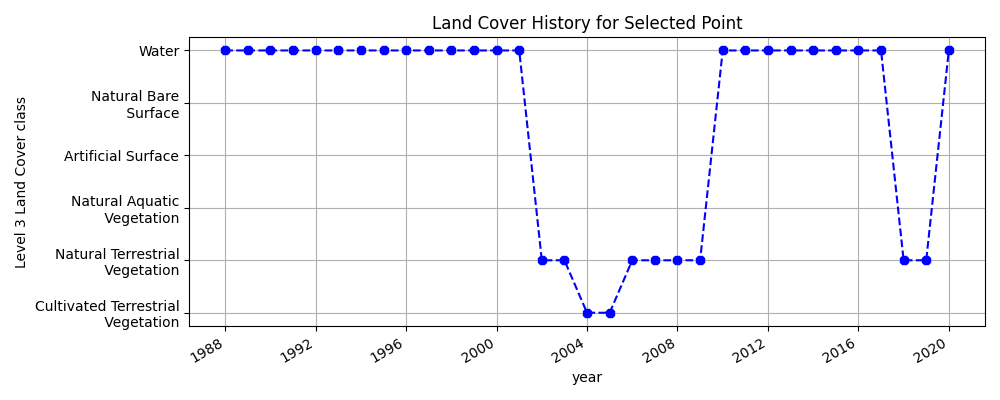

In [12]:
# Define new figure and plot
fig, ax = plt.subplots(figsize=(10, 4))

# Relabel y axis with Level 3 class names
number_labels = (0, 1, 2, 3, 4, 5, 6)
label_classes = (
    "No Data",
    "Cultivated Terrestrial\n Vegetation",
    "Natural Terrestrial\n Vegetation",
    "Natural Aquatic\n Vegetation",
    "Artificial Surface",
    "Natural Bare\n Surface",
    "Water",
)
plt.yticks(number_labels, label_classes)

# Add data to plot
new_data.plot(linestyle="--", c="b", marker="8", mec="b", mfc="b")
plt.xlabel("year")
plt.ylabel("Level 3 Land Cover class")
plt.title("Land Cover History for Selected Point")
plt.grid()
plt.tight_layout()
plt.show

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2020

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.6
